In [1]:
using Pkg
Pkg.add(["CSV", "DataFrames", "MLJ", "MultivariateStats", "PyPlot"])


    Updating registry at `C:\Users\erikf\.julia\registries\General.toml`
   Resolving package versions...
   Installed PyPlot ─ v2.11.6
   Installed PyCall ─ v1.96.4
    Updating `C:\Users\erikf\.julia\environments\v1.12\Project.toml`
  [d330b81b] + PyPlot v2.11.6
    Updating `C:\Users\erikf\.julia\environments\v1.12\Manifest.toml`
  [438e738f] + PyCall v1.96.4
  [d330b81b] + PyPlot v2.11.6
    Building PyCall → `C:\Users\erikf\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\9816a3826b0ebf49ab4926e2b18842ad8b5c8f04\build.log`
Precompiling packages...
  36222.9 ms  ✓ PyCall
   8628.1 ms  ✓ PyPlot
  2 dependencies successfully precompiled in 82 seconds. 468 already precompiled.


In [6]:
Pkg.add("StableRNGs")
include("ML1_Notebooks_RoiCores-main\\ML1_Notebooks_RoiCores-main\\scripts\\ML1Utils.jl")
using .ML1Utils


   Resolving package versions...
   Installed StableRNGs ─ v1.0.4
    Updating `C:\Users\erikf\.julia\environments\v1.12\Project.toml`
  [860ef19b] + StableRNGs v1.0.4
    Updating `C:\Users\erikf\.julia\environments\v1.12\Manifest.toml`
  [860ef19b] ↑ StableRNGs v1.0.3 ⇒ v1.0.4
Precompiling packages...
   2071.4 ms  ✓ StableRNGs
  21490.8 ms  ✓ PlotUtils
   7106.3 ms  ✓ PlotThemes
  10198.8 ms  ✓ RecipesPipeline
 122207.0 ms  ✓ Plots
   6745.3 ms  ✓ Plots → IJuliaExt
   7219.9 ms  ✓ Plots → GeometryBasicsExt
  7 dependencies successfully precompiled in 171 seconds. 463 already precompiled.


In [7]:
using CSV, DataFrames

df = CSV.read("wismd_autoencode_64.csv", DataFrame)

# Qué columnas tenemos
println(first(df, 5))


5×67 DataFrame
 Row │ subject  activity  window_id  emb1      emb2       emb3        emb4     emb5      emb6        emb7       emb8      emb9      emb10      emb11      emb12      emb13     emb14    emb15     emb16       emb17    emb18      emb19    emb20       emb21     emb22       emb23     emb24       emb25      emb26      emb27     emb28      emb29     emb30       emb31     emb32     emb33      emb34       emb35     emb36      emb37       emb38    emb39     emb40     emb41      emb42      emb43    emb44      emb45    emb46     emb47    emb48       emb49       emb50      emb51    emb52     emb53     emb54     emb55       emb56       emb57      emb58     emb59      emb60       emb61       emb62     emb63      emb64      
     │ Int64    String1   Int64      Float64   Float64    Float64     Float64  Float64   Float64     Float64    Float64   Float64   Float64    Float64    Float64    Float64   Float64  Float64   Float64     Float64  Float64    Float64  Float64     Float64   Float64   

In [9]:
valid_classes = ["A", "B", "C", "D", "E"]

mask = in.(df.activity, Ref(valid_classes))

df_filtered = df[mask, :]
println("Filas tras filtrar clases válidas: ", size(df_filtered))


Filas tras filtrar clases válidas: (35347, 67)


In [12]:
Pkg.add("StatsBase")

   Resolving package versions...
   Installed StatsBase ─ v0.34.8
    Updating `C:\Users\erikf\.julia\environments\v1.12\Project.toml`
  [2913bbd2] + StatsBase v0.34.8 [loaded: v0.34.6]
    Updating `C:\Users\erikf\.julia\environments\v1.12\Manifest.toml`
  [2913bbd2] ↑ StatsBase v0.34.6 ⇒ v0.34.8 [loaded: v0.34.6]
Precompiling packages...
   5056.4 ms  ✓ StatsBase
  1 dependency successfully precompiled in 10 seconds. 469 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version. Otherwise, loading dependents of this package may trigger further precompilation to work with the unexpected version.


In [31]:

emb_cols = ["emb$i" for i in 1:64]
y = categorical(df_filtered.activity)
X = Matrix(df_filtered[:, emb_cols]) |> float   # <-- AQUÍ SE DEFINE X
println("Shape X: ", size(X))


skews = [skewness(X[:,i]) for i in 1:64]#Skew muy alto no gausiano
kurts = [kurtosis(X[:,i]) for i in 1:64]

println("Media skewness = ", mean(skews))
println("Media kurtosis = ", mean(kurts))


Shape X: (35347, 64)
Media skewness = 0.04143426643514851
Media kurtosis = 0.7191045946029659


In [32]:
using Statistics
using StatsBase

function adaptive_normalize(X)
    Xn = copy(X)
    nfeat = size(X, 2)
    methods = Vector{String}(undef, nfeat)

    for i in 1:nfeat
        col = X[:, i]

        sk = skewness(col)
        ku = kurtosis(col)

        # Decidir normalización:
        if abs(sk) < 1 && abs(ku-3) < 3
            # Distribución aproximadamente gaussiana → usar Z-score
            μ = mean(col)
            σ = std(col)
            σ = σ == 0 ? 1e-6 : σ
            Xn[:, i] = (col .- μ) ./ σ
            methods[i] = "zscore"
        else
            # Distribución no gaussiana → usar MinMax
            mn = minimum(col)
            mx = maximum(col)
            rng = mx - mn
            rng = rng == 0 ? 1e-6 : rng
            Xn[:, i] = (col .- mn) ./ rng
            methods[i] = "minmax"
        end
    end

    return Xn, methods
end
X_norm, norm_methods = adaptive_normalize(X)

println("Normalización adaptativa completada")
println(norm_methods)

Normalización adaptativa completada
["minmax", "zscore", "zscore", "zscore", "zscore", "zscore", "minmax", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "minmax", "zscore", "zscore", "zscore", "zscore", "minmax", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "minmax", "zscore", "minmax", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "minmax", "zscore", "zscore", "zscore", "minmax", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore", "zscore"]


In [17]:
import Pkg
Pkg.add("MLJ")
Pkg.add("MLJModels")
Pkg.add("MultivariateStats")
Pkg.add("Plots")
Pkg.add("StatsBase")
Pkg.add("DataFrames")


   Resolving package versions...
     Project No packages added to or removed from `C:\Users\erikf\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\erikf\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\erikf\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\erikf\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\erikf\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\erikf\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\erikf\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\erikf\.julia\environments\v1.12\Manifest.toml`
   Resolving pac

In [37]:
train, test = partition(eachindex(y), 0.8, shuffle=true)

train_X = X[train, :]
test_X  = X[test, :]

train_y = y[train]
test_y  = y[test]


7069-element CategoricalArray{String1,1,UInt32}:
 String1("C")
 String1("C")
 String1("B")
 String1("B")
 String1("E")
 String1("D")
 String1("A")
 String1("B")
 String1("B")
 String1("E")
 String1("C")
 String1("D")
 String1("A")
 ⋮
 String1("B")
 String1("E")
 String1("E")
 String1("A")
 String1("E")
 String1("A")
 String1("B")
 String1("C")
 String1("A")
 String1("C")
 String1("B")
 String1("C")

In [38]:
LDA = @load LDA pkg=MultivariateStats verbosity=0
lda_model = LDA()

lda_mach = machine(lda_model, MLJ.table(train_X), train_y)

fit!(lda_mach)



[ Info: Training machine(LDA(method = gevd, …), …).


trained Machine; caches model-specific representations of data
  model: LDA(method = gevd, …)
  args: 
    1:	Source @120 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @229 ⏎ AbstractVector{Multiclass{5}}


In [40]:
import MLJ: transform   # ← IMPORTACIÓN NECESARIA

lda_train_tbl = transform(lda_mach, MLJ.table(train_X))
lda_test_tbl  = transform(lda_mach, MLJ.table(test_X))

lda_train = MLJ.matrix(lda_train_tbl)
lda_test  = MLJ.matrix(lda_test_tbl)

println("Train Patterns ", size(train_X), " -> ", size(lda_train))
println("Test Patterns  ", size(test_X),  " -> ", size(lda_test))


Train Patterns (28278, 64) -> (28278, 4)
Test Patterns  (7069, 64) -> (7069, 4)


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


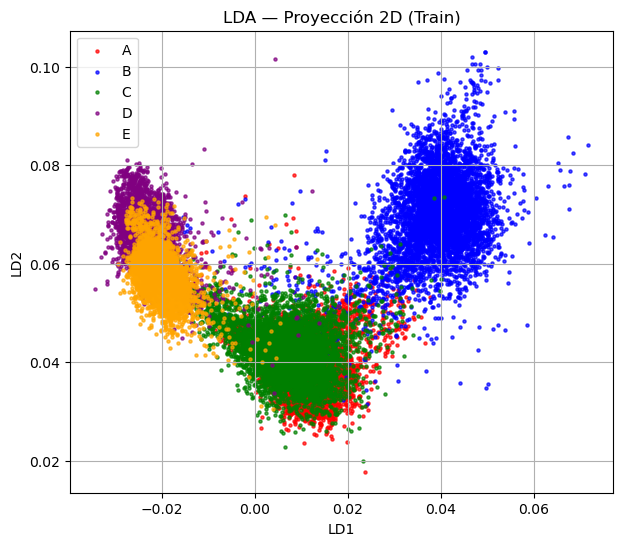

In [44]:
using PyPlot
plt = PyPlot

# Usamos la proyección ya calculada por MLJ
Z = lda_train  # esto es tu LDA proyectado

# Tomamos solo LD1 y LD2
Z2 = Z[:, 1:2]

# Colores
colors = ["red", "blue", "green", "purple", "orange"]
cls = levels(train_y)

plt.figure(figsize=(7,6))

for (i, c) in enumerate(cls)
    idx = findall(train_y .== c)
    plt.scatter(
        Z2[idx, 1],
        Z2[idx, 2],
        c = colors[i],
        label = c,
        s = 5,
        alpha = 0.7
    )
end

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA — Proyección 2D (Train)")
plt.legend()
plt.grid(true)
plt.show()


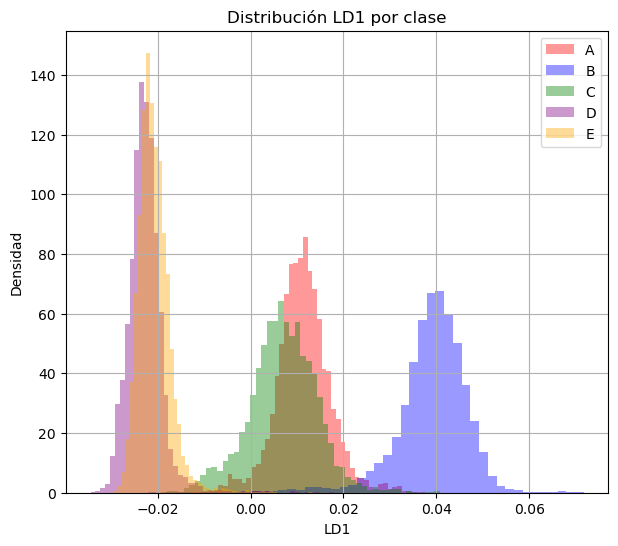

In [49]:
plt.figure(figsize=(7,6))

for (i, c) in enumerate(cls)
    idx = findall(train_y .== c)
    plt.hist(
        Z2[idx],
        bins = 50,
        density = true,
        alpha = 0.4,
        color = colors[i],
        label = c
    )
end

plt.xlabel("LD1")
plt.ylabel("Densidad")
plt.title("Distribución LD1 por clase")
plt.legend()
plt.grid(true)
plt.show()

In [50]:
function modelCrossValidation(modelType::Symbol, modelHyperparameters::Dict,
                              dataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{<:Any,1}},
                              crossValidationIndices::Array{Int64,1})

    # Helper1 : leer "hp" (hyperparameters) aceptando clave String o Symbol
    _get(d::Dict, key::AbstractString, default) = haskey(d, key) ? d[key] :
                                                  haskey(d, Symbol(key)) ? d[Symbol(key)] : default
    # O estandarizar internamente a Symbol todas las claves del Dict
    #hp = Dict{Symbol,Any}(Symbol(k)=>v for (k,v) in modelHyperparameters)

    # Helper2 : mapeo del kernel SVM desde String/Symbol a LIBSVM.Kernel
    function _svm_kernel(kx)
        s = lowercase(String(kx))
        if     s == "linear"      ; return LIBSVM.Kernel.Linear
        elseif s == "rbf"         ; return LIBSVM.Kernel.RadialBasis
        elseif s == "sigmoid"     ; return LIBSVM.Kernel.Sigmoid
        elseif s == "poly" || s == "polynomial"; return LIBSVM.Kernel.Polynomial
        else
            error("Kernel no soportado: $kx (usa \"linear\", \"rbf\", \"sigmoid\" o \"poly\")")
        end
    end

    # Helper3 : construir el modelo MLJ según el tipo
    function _build_model(kind::Symbol, hp::Dict)
        if kind in (:SVC, :SVM, :SVMClassifier)
            kernel = _svm_kernel(_get(hp, "kernel", "rbf"))
            cost   = Float64(_get(hp, "C", 1.0))
            gamma  = Float64(_get(hp, "gamma", 0.0))      # 0.0 => default 1/num_features en LIBSVM
            degree = Int32(_get(hp, "degree", 3))
            coef0  = Float64(_get(hp, "coef0", 0.0))
            return SVMClassifier(kernel=kernel, cost=cost, gamma=gamma, degree=degree, coef0=coef0)
            
        elseif kind in (:DecisionTreeClassifier, :DecisionTree, :DT)
            max_depth = Int(_get(hp, "max_depth", 8))
            seed      = Int(_get(hp, "seed", 1))
            return DTClassifier(max_depth=max_depth, rng=Random.MersenneTwister(seed))
            
        elseif kind in (:KNNClassifier, :KNeighborsClassifier, :kNN, :kNNClassifier)
            K = Int(_get(hp, "K", 5))
            return kNNClassifier(K=K)
            
        else
            error("Tipo de modelo no soportado para MLJ: $kind")
        end
    end

    
    # CASO ANN : delegar en función ANNCrossValidation del Unit5
    if modelType == :ANN
        @assert haskey(modelHyperparameters, "topology") || haskey(modelHyperparameters, :topology) "Falta 'topology' en modelHyperparameters para :ANN"
        topology = _get(modelHyperparameters, "topology", nothing)

        # parámetros opcionales si vienen 
        kwargs = Dict{Symbol,Any}()
        for ksym in (:numExecutions, :transferFunctions, :maxEpochs, :minLoss, :learningRate, :validationRatio, :maxEpochsVal)
            v = _get(modelHyperparameters, String(ksym), nothing)
            if v !== nothing
                kwargs[ksym] = v
            end
        end

        return ANNCrossValidation(topology, dataset, crossValidationIndices; (; kwargs...)...)
    end

    
    # CASO MLJ (SVM, DT o kNN)
    X, y_any = dataset
    
    y = string.(y_any)  # convertir etiquetas a String para evitar problemas
    classes = unique(y)
    k = maximum(crossValidationIndices)

    # vectores para las métricas por fold
    accs = Float64[]; errs = Float64[]; senss = Float64[]; specs = Float64[]
    ppvs = Float64[]; npvs = Float64[]; f1s  = Float64[]

    # CM global
    C = length(classes)
    cm_global = zeros(Int, C, C)

    for fold in 1:k
        train_mask = crossValidationIndices .!= fold
        test_mask  = .!train_mask

        Xtr, ytr = X[train_mask, :], y[train_mask]
        Xte, yte = X[test_mask,  :], y[test_mask]

        model = _build_model(modelType, modelHyperparameters)
        mach = machine(model, MLJ.table(Xtr), categorical(ytr))
        MLJ.fit!(mach, verbosity=0)

        yhat = MLJ.predict(mach, MLJ.table(Xte))

        # SVM devuelve CategoricalArray (etiqueta directa); kNN/DT devuelven UnivariateFinite (usar mode)
        ŷ_labels = if modelType in (:SVC, :SVM, :SVMClassifier)
            string.(yhat)
        elseif modelType in (:DecisionTreeClassifier, :DecisionTree, :DT, :KNNClassifier, :KNeighborsClassifier, :kNN, :kNNClassifier)
            string.(mode.(yhat))
        else
            error("Tipo de modelo no soportado: $modelType")
        end

        acc, err, sens, spec, ppv, npv, f1, cm = confusionMatrix(ŷ_labels, yte, classes)
        push!(accs, acc); push!(errs, err); push!(senss, sens); push!(specs, spec)
        push!(ppvs, ppv); push!(npvs, npv); push!(f1s, f1)
        cm_global .+= cm  
    end

    
    return (
        (Statistics.mean(accs),  Statistics.std(accs)),
        (Statistics.mean(errs),  Statistics.std(errs)),
        (Statistics.mean(senss), Statistics.std(senss)),
        (Statistics.mean(specs), Statistics.std(specs)),
        (Statistics.mean(ppvs),  Statistics.std(ppvs)),
        (Statistics.mean(npvs),  Statistics.std(npvs)),
        (Statistics.mean(f1s),   Statistics.std(f1s)),
        cm_global
    )
end

modelCrossValidation (generic function with 1 method)

In [51]:
import Downloads, Serialization, Random
using Statistics, MLJ, CategoricalArrays

mkpath("modelosTraining")


"modelosTraining"

In [52]:
function train_and_save(modelType::Symbol, hp::Dict, X, y, name::String)
    println("\n============================")
    println(" ENTRENANDO $modelType ($name)")
    println("============================\n")

    # entrenar con CV
    stats = modelCrossValidation(modelType, hp, (X, y), cvIndex)

    println("→ Accuracy medio  =", stats[1][1])
    println("→ Std accuracy    =", stats[1][2])
    println("→ F1 medio        =", stats[7][1])
    println("→ Std F1          =", stats[7][2])
    println("\nMatriz Confusión global:\n", stats[end])

    # ENTRENAR MODELO FINAL EN TODO EL DATASET
    model = nothing
    if modelType == :ANN
        topology = hp["topology"]
        model = ANNTrainFull(topology, (X,y); hp...)
    else
        mljModel = _build_model(modelType, hp)
        mach = machine(mljModel, MLJ.table(X), categorical(y))
        MLJ.fit!(mach, verbosity=0)
        model = mach
    end

    # GUARDAR
    file = "modelosTraining/$(name)_$(modelType).jls"
    Serialization.serialize(file, model)
    println("\n✔ Modelo guardado en: $file\n")

    return stats, model
end


train_and_save (generic function with 1 method)

In [54]:
using Random

k = 5                               # número de folds
N = size(X, 1)                      # nº de muestras
cvIndex = rand(1:k, N)              # asignar fold aleatorio a cada fila

println("CV listo: ", counts(cvIndex))


CV listo: [7147, 7025, 7168, 7091, 6916]


In [ ]:
using Pkg

Pkg.add("MLJ")
Pkg.add("MLJModels")
Pkg.add("LIBSVM")
Pkg.add("DecisionTree")
Pkg.add("NearestNeighborModels")




[ Info: For silent loading, specify `verbosity=0`. 


LoadError: ArgumentError: There is no model named "LIBSVMClassifier" in the registry. 
 Run `models()` to view all registered models, or `models(needle)` to restrict search to models with string `needle` in their name or documentation. 

In [61]:
stats_ann, model_ann = train_and_save(
    :ANN,
    Dict(
        "topology" => [256, 256, 256],
        "maxEpochs" => 100,
        "learningRate" => 0.015,
        "numExecutions" => 1
    ),
    X, y,
    "ann_4_16_5"
)



 ENTRENANDO ANN (ann_4_16_5)

→ Accuracy medio  =0.9695264002519337
→ Std accuracy    =0.0033098250589421404
→ F1 medio        =0.9696028630653633
→ Std F1          =0.0033325641751058717

Matriz Confusión global:
[7063.0 50.0 30.0 3.0 0.0; 65.0 7003.0 82.0 3.0 5.0; 13.0 17.0 6650.0 35.0 295.0; 5.0 0.0 45.0 6776.0 50.0; 3.0 4.0 340.0 33.0 6777.0]


LoadError: TypeError: in typeassert, expected Symbol, got a value of type String

In [ ]:
stats_ann, model_ann = train_and_save(
    :ANN,
    Dict(
        "topology" => [200, 250, 200],
        "maxEpochs" => 100,
        "learningRate" => 0.015,
        "numExecutions" => 1
    ),
    X, y,
    "ann_4_16_5"
)


In [ ]:
stats_svm, model_svm = train_and_save(
    :LIBSVMClassifier,
    Dict(
        "kernel" => "rbf",
        "C" => 1.0,
        "gamma" => 0.01
    ),
    X, y,
    "svm_rbf"
)



 ENTRENANDO LIBSVMClassifier (svm_rbf)



LoadError: Tipo de modelo no soportado para MLJ: LIBSVMClassifier

In [65]:
stats_knn, model_knn = train_and_save(
    :KNNClassifier,
    Dict(
        "K" => 7
    ),
    X, y,
    "knn7"
)



 ENTRENANDO KNNClassifier (knn7)



LoadError: UndefVarError: `kNNClassifier` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [66]:
stats_dt, model_dt = train_and_save(
    :DecisionTreeClassifier,
    Dict(
        "max_depth" => 10
    ),
    X, y,
    "decisionTree10"
)



 ENTRENANDO DecisionTreeClassifier (decisionTree10)



LoadError: UndefVarError: `DTClassifier` not defined in `Main`
Suggestion: check for spelling errors or missing imports.